# CALC DISTANCE METHODS

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import fiona as fio
from haversine import haversine, Unit


In [3]:
from common.helpers import utm_crs_from_latlon
fdata = gpd.read_file('../test_data/airport.geojson', engine='fiona')
fdata.set_crs(4326, inplace=True)
xs, ys = fdata["geometry"][0].exterior.coords.xy # (x: lon, y: lat)

# length in JOSM - file square.gml
print(f'Correct length in JOSM\t{15591}')

# length in haversine
haversine_len = 0
for i in range(1,len(xs)):
    p0 = (ys[i-1], xs[i-1])
    p1 = (ys[i], xs[i])
    haversine_len += haversine(p0, p1, unit=Unit.METERS) # (lat, lon)
print(f'Length in Haversine\t{haversine_len}')

# length in utm
centroid = fdata["geometry"][0].centroid
utm_crs = utm_crs_from_latlon(lat = centroid.y,
                                lon = centroid.x)
print(f'Length in UTM CRS\t{fdata.to_crs(utm_crs).length[0]}')

# length in 3857
print(f'Length in CRS:3857\t{fdata.to_crs(3857).length[0]}')

Correct length in JOSM	15591
Length in Haversine	15573.724398426486
Length in UTM CRS	15551.849684898425
Length in CRS:3857	15873.208167118197


# WRITE FILE

In [116]:
# import osmnx as ox
# import folium
# gdf_airport = ox.geocode_to_gdf('W54242195', by_osmid=True) # san bay tan son nhat
# gdf_stadium = ox.geocode_to_gdf('W750361871', by_osmid=True) # san van dong quan khu 7

# columns = ['geometry']
# gdf_airport = gdf_airport[columns]
# gdf_stadium = gdf_stadium[columns]

# gdf_districts = gpd.read_file('C:/Users/Huynh Tan Thanh/Downloads/Vietnam_Demographic_Data_(Huyen)_S.geojson')
# district_cols = ["OBJECTID", "geometry", "NAME_2"]
# gdf_districts = gdf_districts[district_cols]
# district_ids = [266,279]
# gdf_districts = gdf_districts[gdf_districts["OBJECTID"].isin(district_ids)]
# gdf_districts.reset_index(inplace=True,drop=True)

# # write file
# gdf_airport.to_file('../test_data/airport.geojson', driver='GeoJSON')
# gdf_stadium.to_file('../test_data/stadium.geojson', driver='GeoJSON')
# gdf_districts.to_file('../test_data/districts.geojson', driver='GeoJSON')

# Load data & Implement overlay operators

In [26]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

gdf_airport = gpd.read_file('../test_data/airport.geojson')
gdf_stadium = gpd.read_file('../test_data/stadium.geojson')
gdf_districts = gpd.read_file('../test_data/districts.geojson')
gdf_river = gpd.read_file('../test_data/Amazon_river.geojson')

## Overlay operators:
![overlay operators](../test_data/overlay_operations.png)
- Intersection
- Union
- Difference
- Symetrical Difference
## Others:
- Centroids
- Convex Hull
- Simplify

### 1. Intersection

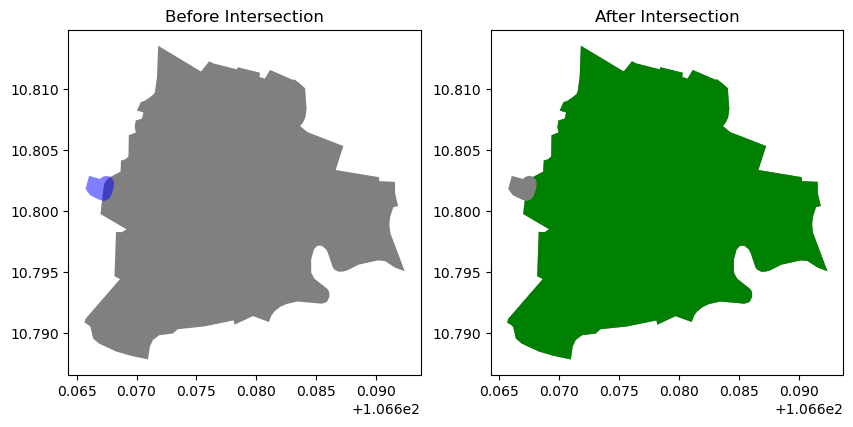

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Prepare data
gdf_1 = gdf_districts[:1]
gdf_2 = gdf_stadium

# Plot before
ax = gdf_1.plot(ax= axs[0],color='gray')
gdf_2.plot(ax=axs[0], color='blue', alpha=0.5)
ax.set_title('Before Intersection')
# Plot after
gdf_intersect = gdf_1.overlay(gdf_2, how='difference')
if not gdf_intersect.empty:
    ax = gdf_1.plot(ax=axs[1],color='gray')
    gdf_2.plot(ax=ax, color='gray')

    gdf_intersect.plot(ax=ax, color='green')
    ax.set_title('After Intersection')
else:
    axs[1].set_title('Empty overlay')

### Centroids

MULTIPOINT (106.6777375157387 10.800298628214874, 106.65183297462451 10.808735183374235)


C:\Users\Huynh Tan Thanh\AppData\Local\Temp\ipykernel_18756\1867543623.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid


Text(0.5, 1.0, 'Centroid')

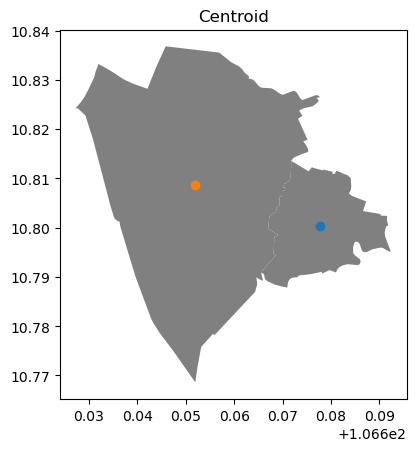

In [45]:
from shapely import MultiPoint
gdf = gdf_districts
centroids = gdf.centroid
centroids = MultiPoint(centroids)
print(centroids)

# Plot
ax = gdf.plot(color='gray')
for p in centroids.geoms:
    ax.scatter(p.xy[0], p.xy[1])
ax.set_title('Centroid')

### Simplify

Text(0.5, 1.0, 'Simplify')

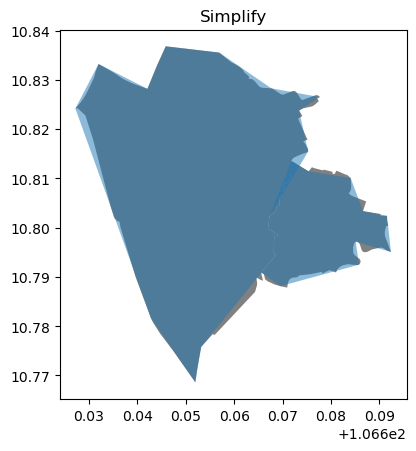

In [21]:
gdf = gdf_districts
# Generalize geometry
gdf_simplify = gdf.simplify(tolerance=90/43200)

# Plot
ax = gdf.plot(color='gray')
gdf_simplify.plot(ax=ax, alpha=0.5)
ax.set_title('Simplify')

### Convex Hull

Text(0.5, 1.0, 'Convex Hull')

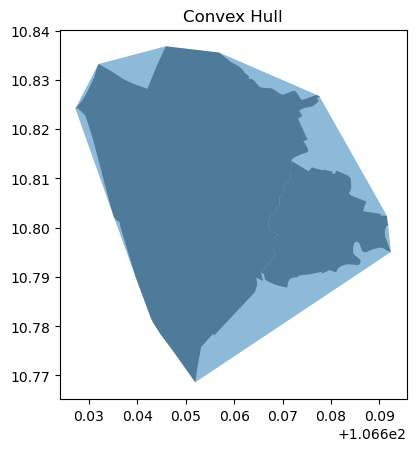

In [22]:
gdf = gdf_districts
convex_hull = gdf.unary_union.convex_hull
gdf_convex_hull = gdf[:1].copy()
gdf_convex_hull.geometry = [convex_hull]
#plot
ax = gdf.plot(color='gray')
gdf_convex_hull.plot(ax=ax, alpha=0.5)
ax.set_title('Convex Hull')

In [60]:
# import folium
# map = folium.Map(location=[10.817778935719275, 106.65619538171518],
#                     tiles="Cartodb dark_matter", zoom_start=13)
# map

# CONVERT GEOJSON TO GML

In [61]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from pygml.v32 import encode_v32
from lxml import etree

try:
    gdf = gpd.read_file('../test_data/districts.geojson')
    tree = encode_v32(gdf.__geo_interface__['features'][0]['geometry'], 'ID')
    print(etree.tostring(tree, pretty_print=True).decode())
    target = tree.xpath('.//gml:geometryMembers',namespaces=tree.nsmap)
    if len(target)!=0:
        target[0].tag = "pointMembers"
    print(etree.tostring(tree, pretty_print=True).decode())
except Exception as e:
    print('Oops!', e)
    print(type(e))

<gml:Polygon xmlns:gml="http://www.opengis.net/gml/3.2" srsName="urn:ogc:def:crs:OGC::CRS84" gml:id="ID">
  <gml:exterior>
    <gml:LinearRing>
      <gml:posList>106.675384521 10.811444282652 106.676063538 10.8122777936519 106.676452637 10.8121013636519 106.678382874 10.8116188046519 106.678451538 10.8117942806519 106.68031311 10.8113441466519 106.680274963 10.8109951016519 106.680709839 10.810855865652 106.681144714 10.8115692136519 106.683082581 10.8107519146519 106.683166504 10.8108053206519 106.683586121 10.8104963306519 106.684074402 10.810069084652 106.684196472 10.808363914652 106.684104919 10.807696342652 106.683914185 10.8072919846521 106.683662415 10.8069677356521 106.684280396 10.8064718246521 106.687271118 10.8053302766521 106.68662262 10.8033647536522 106.690238953 10.8027801516522 106.690261841 10.8024539946522 106.691574097 10.8023967746522 106.691589355 10.8014440536522 106.691833496 10.8004140856523 106.691436768 10.8003196716523 106.691184998 10.7995681766523 106.691

## Buffer

In [99]:
gdf_utm["geometry"][0].geom_type

'Polygon'

In [44]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from common.helpers import utm_crs_from_latlon


gdf = gpd.read_file('../test_data/districts.geojson')
centroid = gdf.unary_union.centroid
# get utm from coords
utm_crs = utm_crs_from_latlon(centroid.y, centroid.x)
gdf_utm = gdf.to_crs(utm_crs)
gdf_utm["geometry"] = gdf_utm.buffer(100)
gdf_utm= gdf_utm.to_crs(4326)

from shapely import MultiPolygon
print(MultiPolygon(list(gdf_utm["geometry"])))

MULTIPOLYGON (((106.66533520095665 10.789992360762438, 106.66518411963163 10.79008263147594, 106.66510890019342 10.790132773795314, 106.66503907645433 10.790190038871625, 106.66497533573626 10.790253863010118, 106.6649183054834 10.790323617950584, 106.66486854708583 10.790398617051622, 106.66482655035333 10.790478122049556, 106.6647927286936 10.79056135032555, 106.66476741504265 10.790647482609351, 106.6647508585872 10.79073567104385, 106.66474322231147 10.790825047531072, 106.66474458139255 10.79091473227743, 106.66475492246005 10.79100384245416, 106.66477414372733 10.791091500887635, 106.66485806696602 10.791399538246955, 106.66488335776418 10.791477960152946, 106.6649157580625 10.791553782676482, 106.66495499927015 10.791626377255463, 106.66500075608502 10.791695142086835, 106.66505264919039 10.791759507115565, 106.66731529542744 10.79431771790862, 106.66729783666209 10.794359910133494, 106.66727288562252 10.794441327846288, 106.6672557857317 10.794524703915561, 106.66724668842205 1

<Axes: >

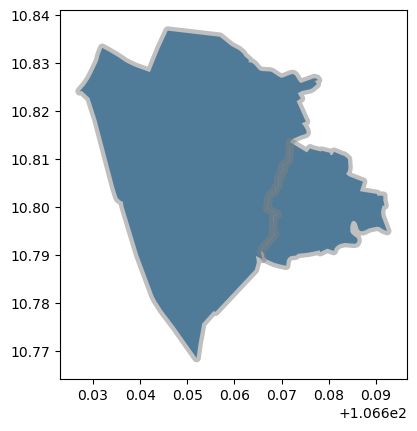

In [45]:
ax = gdf.plot()
gdf_utm.plot(ax=ax,alpha=0.5, color='gray')

# GDAL lib

In [65]:
import os
os.environ['USE_PYGEOS'] = '0'
from osgeo import ogr
import geopandas as gpd
import json

gdf = gpd.read_file("../test_data/districts.geojson")
geojson = json.dumps(gdf.__geo_interface__['features'][0]['geometry'])
point = ogr.CreateGeometryFromJson(geojson)
print(point.ExportToGML(options = ['NAMESPACE_DECL=YES']))

<gml:Polygon xmlns:gml="http://www.opengis.net/gml" srsName="EPSG:4326"><gml:outerBoundaryIs><gml:LinearRing><gml:coordinates>106.675384521,10.811444282652 106.676063538,10.8122777936519 106.676452637,10.8121013636519 106.678382874,10.8116188046519 106.678451538,10.8117942806519 106.68031311,10.8113441466519 106.680274963,10.8109951016519 106.680709839,10.810855865652 106.681144714,10.8115692136519 106.683082581,10.8107519146519 106.683166504,10.8108053206519 106.683586121,10.8104963306519 106.684074402,10.810069084652 106.684196472,10.808363914652 106.684104919,10.807696342652 106.683914185,10.8072919846521 106.683662415,10.8069677356521 106.684280396,10.8064718246521 106.687271118,10.8053302766521 106.68662262,10.8033647536522 106.690238953,10.8027801516522 106.690261841,10.8024539946522 106.691574097,10.8023967746522 106.691589355,10.8014440536522 106.691833496,10.8004140856523 106.691436768,10.8003196716523 106.691184998,10.7995681766523 106.691108704,10.7989377976523 106.691177368

In [71]:
from lxml import etree

# define namespaces
nsmap = {
    'wfs':'http://www.opengis.net/wfs',
    'gml':'http://www.opengis.net/gml',
    'feature':'http://mapserver.gis.umn.edu/mapserver'
}
root = etree.Element(etree.QName(nsmap['wfs'],'FeatureCollection'),nsmap=nsmap)
for fea in gdf.__geo_interface__['features']:
    geojson = json.dumps(fea['geometry'])
    geom_gml = ogr.CreateGeometryFromJson(geojson).ExportToGML(options = ['NAMESPACE_DECL=YES'])
    geom_tree = etree.fromstring(geom_gml)
    # create gml tree
    featureMember = etree.SubElement(root, etree.QName(nsmap['gml'],'featureMember'))
    features = etree.SubElement(featureMember, etree.QName(nsmap['feature'],'features'))
    geom = etree.SubElement(features, etree.QName(nsmap['feature'],'geometry'))
    geom.insert(0,geom_tree)
print(etree.tostring(root, pretty_print=True).decode())

<wfs:FeatureCollection xmlns:wfs="http://www.opengis.net/wfs" xmlns:gml="http://www.opengis.net/gml" xmlns:feature="http://mapserver.gis.umn.edu/mapserver">
  <gml:featureMember>
    <feature:features>
      <feature:geometry>
        <gml:Polygon srsName="EPSG:4326">
          <gml:outerBoundaryIs>
            <gml:LinearRing>
              <gml:coordinates>106.675384521,10.811444282652 106.676063538,10.8122777936519 106.676452637,10.8121013636519 106.678382874,10.8116188046519 106.678451538,10.8117942806519 106.68031311,10.8113441466519 106.680274963,10.8109951016519 106.680709839,10.810855865652 106.681144714,10.8115692136519 106.683082581,10.8107519146519 106.683166504,10.8108053206519 106.683586121,10.8104963306519 106.684074402,10.810069084652 106.684196472,10.808363914652 106.684104919,10.807696342652 106.683914185,10.8072919846521 106.683662415,10.8069677356521 106.684280396,10.8064718246521 106.687271118,10.8053302766521 106.68662262,10.8033647536522 106.690238953,10.802780151

In [73]:
type(etree.tostring(root, pretty_print=True).decode())

str